### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ks_2samp

### Load Datasets & Data Preprocessing

#### Data Cleaning and Aggregation

In [2]:
# Load raw datasets
df_wave = pd.read_csv('WLIS_wave_raw.csv')
df_wind = pd.read_csv('WLIS_wind_raw.csv')

# Set the timestamp column as the index
df_wave['TmStamp'] = pd.to_datetime(df_wave['TmStamp'], format='mixed')
df_wind['TmStamp'] = pd.to_datetime(df_wind['TmStamp'], format='mixed')
df_wave.set_index('TmStamp', inplace=True)
df_wind.set_index('TmStamp', inplace=True)

# Rename columns
df_wave = df_wave.rename(columns={'Hsig_m':'H'})
df_wind = df_wind.rename(columns={'windSpd_Kts':'WSPD', 'windDir_M':'WDIR'})

# In total 118,872 hourly timestamps
date_ranges = [
    ('2004-11-01 00:00:00', '2015-01-05 23:00:00'),  # 89232 hourly timestamps
    ('2016-12-12 00:00:00', '2018-01-11 23:00:00'),  # 9504 hourly timestamps
    ('2018-04-27 00:00:00', '2018-10-22 23:00:00'),  # 4296 hourly timestamps
    ('2019-05-28 00:00:00', '2019-12-31 23:00:00'),  # 5232 hourly timestamps
    ('2022-12-09 00:00:00', '2023-06-02 23:00:00'),  # 4224 hourly timestamps
    ('2024-03-28 00:00:00', '2024-12-18 23:00:00')]  # 6384 hourly timestamps

# Filter date ranges
ndf_wave = pd.DataFrame()
ndf_wind = pd.DataFrame()
date_ranges[0] = ('2006-02-23 00:00:00', '2015-01-05 23:00:00')
for start, end in [(pd.to_datetime(start), pd.to_datetime(end[:-5] + '59:59')) for start, end in date_ranges]:
    ndf_wave = pd.concat([ndf_wave, df_wave[(df_wave.index >= start) & (df_wave.index <= end)]])
    ndf_wind = pd.concat([ndf_wind, df_wind[(df_wind.index >= start) & (df_wind.index <= end)]])

# Remove outliers
ndf_wind.loc[ndf_wind['WSPD'] > 50, 'WSPD'] = np.nan

# Resample by hour
ndf_wave = ndf_wave.resample('h').max()
ndf_wind = ndf_wind.resample('h').max()

# Convert units
ndf_wave['H'] = 3.28084 * ndf_wave['H']         # m to ft
ndf_wind['WSPD'] = 0.514444 * ndf_wind['WSPD']  # kts to m/s

# Fill in the missing timestamps
timestamps = []
date_ranges[0] = ('2004-11-01 00:00:00', '2015-01-05 23:00:00')
for start, end in [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in date_ranges]:
    timestamps.extend(pd.date_range(start, end, freq='h'))

# Merge datasets
df_merge = pd.merge(ndf_wave, ndf_wind, how='outer', left_index=True, right_index=True)
df_merge = pd.merge(pd.DataFrame(timestamps, columns=['TmStamp']), df_merge, on='TmStamp', how='left')
df_merge = df_merge.sort_values(by='TmStamp').reset_index(drop=True)

#### Data Imputation Using the 2004-2013 Buoy Dataset

In [ ]:
# Load 2004-2013 buoy dataset
df_buoy = pd.read_csv('Data_Buoy_2004_2013.csv')
df_buoy = df_buoy.rename(columns={'TimeStamp_1':'TmStamp', 'WSPD':'WSPD1', 'WDIR':'WDIR1'})
df_buoy['TmStamp'] = pd.to_datetime(df_buoy['TmStamp'], format='mixed')

# First imputation
df_new = pd.merge(df_merge, df_buoy[['TmStamp','SWHft','WSPD1','WDIR1']], on='TmStamp', how='left')
df_new['H'] = df_new['H'].fillna(df_new['SWHft'])
df_new['WSPD'] = df_new['WSPD'].fillna(df_new['WSPD1'])
df_new['WDIR'] = df_new['WDIR'].fillna(df_new['WDIR1'])
df_new = df_new[['TmStamp', 'H', 'WSPD', 'WDIR']]

,TmStamp,H,WSPD,WDIR
0,2004-11-01 00:00:00,3.249133,13.4,120.0
1,2004-11-01 01:00:00,3.249133,8.2,80.0
2,2004-11-01 02:00:00,1.960359,7.7,340.0
3,2004-11-01 03:00:00,2.001249,10.3,10.0
4,2004-11-01 04:00:00,3.254957,11.8,50.0


#### Wind Data Imputation

In [ ]:
# Split dataset
def split_season(df):
    df = df.copy()
    df['month'] = pd.to_datetime(df['TmStamp']).dt.month

    windy_mask = df['month'].isin([11, 12, 1, 2, 3])
    calm_mask = df['month'].isin([4, 5, 6, 7, 8, 9, 10])

    return df[windy_mask], df[calm_mask]

# Wind imputation
def impute_wind(df):
    df = df.copy()
    
    # Calculate the run lengths for consecutive NaNs
    def get_run_lengths(series):
        arr = series.isna().astype(int).values
        result = arr[:]
        count, idx = 0, -1
        for i in range(len(arr)):
            if arr[i] == 0:
                if idx != -1 and count > 0:
                    for j in range(idx+1, i):
                        if arr[j] == 1:
                            result[j] = count
                count, idx = 0, i
            else:
                count += 1
        return result

    # Case 1: Interpolate when run_lengths ≤ 5
    WSPD_run_lengths = get_run_lengths(df['WSPD'])
    WDIR_run_lengths = get_run_lengths(df['WDIR'])
    WSPD_mask = (WSPD_run_lengths > 0) & (WSPD_run_lengths <= 5)
    WDIR_mask = (WDIR_run_lengths > 0) & (WDIR_run_lengths <= 5)

    WSPD = df['WSPD'].interpolate(method='linear')
    WDIR = df['WDIR'].interpolate(method='linear')

    n_random = np.random.normal(loc=0, scale=1, size=len(df))
    sd_WSPD = np.std(df['WSPD'].dropna())
    WSPD += n_random * sd_WSPD

    df.loc[WSPD_mask, 'WSPD'] = WSPD[WSPD_mask]
    df.loc[WDIR_mask, 'WDIR'] = WDIR[WDIR_mask]

    # Case 2: Sample from known good pairs when run_lengths > 5
    mask = WSPD_run_lengths > 5
    observed = df[['WSPD','WDIR']].dropna()
    sampled = observed.sample(n=mask.sum(), replace=True)
    df.loc[mask, ['WSPD','WDIR']] = sampled.values
    
    return df

df_windy, df_calm = split_season(df_new)
df_new = pd.concat([impute_wind(df_windy), impute_wind(df_calm)])
df_new = df_new.sort_values(by='TmStamp').reset_index(drop=True)

47664
71208


#### Wave Data Imputation

In [ ]:
# Wave imputation
def impute_wave(df):
    df = df.copy()
    df['month'] = df['TmStamp'].dt.month
    df['season'] = np.where(df['month'].isin([11, 12, 1, 2, 3]), 'windy', 'calm')

    # Create wind speed quartile bins
    df['rWSPD'] = df['WSPD'] ####################################
    quartiles = df['rWSPD'].quantile([0.25, 0.5, 0.75])
    df['bin'] = pd.cut(
        df['rWSPD'],
        bins = [-np.inf, quartiles[0.25], quartiles[0.5], quartiles[0.75], np.inf],
        labels = ['Q1','Q2','Q3','Q4'])
    
    # Impute missing wave heights
    damp = {'windy':0.03, 'calm':0.01}
    for season in ['calm','windy']:
        df_season = df[df['season'] == season]
        for label in ['Q1','Q2','Q3','Q4']:
            # Impute NaN with the median of each bin
            bin_mask = (df['bin'] == label) & (df['season'] == season) & (df['H'].isna())
            obs_median = df_season[df_season['bin'] == label]['H'].median()

            # Inject randomness based on damping
            n_random = np.random.normal(loc=0, scale=1, size=bin_mask.sum())
            df.loc[bin_mask, 'H'] = obs_median + damp[season] * n_random
    
    return df

df_new = impute_wave(df_new)

#### Fetch Calculation

In [ ]:
def calculate_fetch(df, dir_col='WDIR', which_buoy='central'):
    df = df.copy()

    # Define fetch table based on compass degrees
    fetch_data = [
        (0 , 3 , 9), (10 , 5 , 10), (20 , 5 , 10), (30 , 10 , 10), (40 , 12 , 10),
        (50 , 17 , 15), (60 , 40 , 16), (70 , 75 , 40), (80 , 61 , 55), (90 , 22 , 15),
        (100 , 17 , 14), (110 , 11 , 11), (120 , 4 , 11), (130 , 4 , 11), (140 , 3 , 10),
        (150 , 3 , 10), (160 , 3 , 11), (170 , 3 , 11), (180 , 3 , 11), (190 , 3 , 11),
        (200 , 3 , 12), (210 , 4 , 14), (220 , 5 , 15), (230 , 10 , 19), (240 , 14 , 25),
        (250 , 11 , 40), (260 , 8 , 53), (270 , 7 , 31), (280 , 6 , 23), (290 , 5 , 19),
        (300 , 5 , 17), (310 , 5 , 14), (320 , 5 , 11), (330 , 5 , 10), (340 , 5 , 8),
        (350 , 4 , 9), (360 , 3 , 9)
    ]

    fetch_df = pd.DataFrame(fetch_data, columns=['Deg', 'wlisMiles', 'clisMiles'])

    # Merge by compass direction
    df = df.merge(fetch_df, how='left', left_on=dir_col, right_on='Deg')

    # Convert miles to meters
    miles_to_meters = 1609.34
    if which_buoy == 'central':
        df['Fetch'] = df['clisMiles'] * miles_to_meters
    elif which_buoy == 'western':
        df['Fetch'] = df['wlisMiles'] * miles_to_meters
    else:
        raise ValueError("which_buoy must be either 'central' or 'western'")

    return df

# Assuming you have a DataFrame 'df' with a 'WDIR' column
df_with_fetch = calculate_fetch(df, dir_col='WDIR', which_buoy='central')


#### Description of features
- **WSPD**: Wind speed (*u*)
- **WDIR**: Wind direction
- **Fetch**: Fetch distance (*F*)
- **uSq**: $u^2$
- **e_uSq**: East component of $u^2$
- **n_uSq**: North component of $u^2$
- $Z_2 = u\sqrt{F}$
- $Z_3 = F$
- $Z_4 = \frac{F^{3/2}}{u}$

#### Description of target
- **H**: Significant wave height (ft)

In [ ]:
wind_cols = ['u','uSq','e_uSq','n_uSq','Z2','Z3','Z4']

# Load datasets
df_buoy_04_13 = pd.read_csv('Data_Buoy_2004_2013.csv')
df_stn_04_13 = pd.read_csv('Data_Sikorsky_2004_2013.csv')
df_stn_73_04 = pd.read_csv('Data_Sikorsky_1973_2004.csv')

# Rename columns
df_buoy_04_13 = df_buoy_04_13.rename(columns={'SWHft':'H'})
df_stn_04_13 = df_stn_04_13.rename(columns={'Fetch':'Z3'})
df_stn_73_04 = df_stn_73_04.rename(columns={'Fetch':'Z3'})

# Add transformed wind speed (u)
df_stn_04_13['u'] = df_stn_04_13['rWSPD_T'].shift(-1).ffill()
df_stn_73_04['u'] = df_stn_73_04['rWSPD_T'].shift(-1).ffill()

# Add squared terms (u^2)
df_stn_04_13['uSq'] = df_stn_04_13['u']**2
df_stn_73_04['uSq'] = df_stn_73_04['u']**2

# Add east and north components (e_uSq, n_uSq)
alpha = -13
df_stn_04_13['rad'] = np.pi/180 * ((alpha + 630 - df_stn_04_13['WDIR']) % 360)
df_stn_73_04['rad'] = np.pi/180 * ((alpha + 630 - df_stn_73_04['WDIR']) % 360)
df_stn_04_13['e_uSq'] = df_stn_04_13['uSq'] * np.cos(df_stn_04_13['rad'])
df_stn_73_04['e_uSq'] = df_stn_73_04['uSq'] * np.cos(df_stn_73_04['rad'])
df_stn_04_13['n_uSq'] = df_stn_04_13['uSq'] * np.sin(df_stn_04_13['rad'])
df_stn_73_04['n_uSq'] = df_stn_73_04['uSq'] * np.sin(df_stn_73_04['rad'])

# Add interaction terms (Z2, Z4)
df_stn_04_13['Z2'] = np.sqrt(df_stn_04_13['Z3']) * df_stn_04_13['u']
df_stn_73_04['Z2'] = np.sqrt(df_stn_73_04['Z3']) * df_stn_73_04['u']
df_stn_04_13['Z4'] = (df_stn_04_13['Z3']**1.5) / df_stn_04_13['u']
df_stn_73_04['Z4'] = (df_stn_73_04['Z3']**1.5) / df_stn_73_04['u']

# Data aggregation
df1 = pd.concat([df_buoy_04_13[['TimeStamp_1','H']], df_stn_04_13[wind_cols]], axis=1)
df2 = df_stn_73_04[['TimeStamp_1'] + wind_cols].copy()

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df2['TimeStamp_1'] = pd.to_datetime(df2['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)
df2.set_index('TimeStamp_1', inplace=True)

df1.head()

,H,u,uSq,e_uSq,n_uSq,Z2,Z3,Z4
TimeStamp_1,,,,,,,,
2004-11-01 00:00:00,3.249133,4.38474,19.225945,18.733185,-4.324897,556.247086,16093.4,465615.964363
2004-11-01 01:00:00,3.249133,6.87748,47.299731,-43.539632,18.481477,872.475497,16093.4,296853.635864
2004-11-01 02:00:00,1.960359,6.56483,43.096993,-23.472305,-36.144180,832.812792,16093.4,310991.288972
2004-11-01 03:00:00,2.001249,5.31423,28.241040,-25.162951,-12.821164,674.161969,16093.4,384177.000917
2004-11-01 04:00:00,3.254957,5.93953,35.278017,-19.213785,-29.586634,753.487381,16093.4,343731.733585


### Distribution of Features & Target

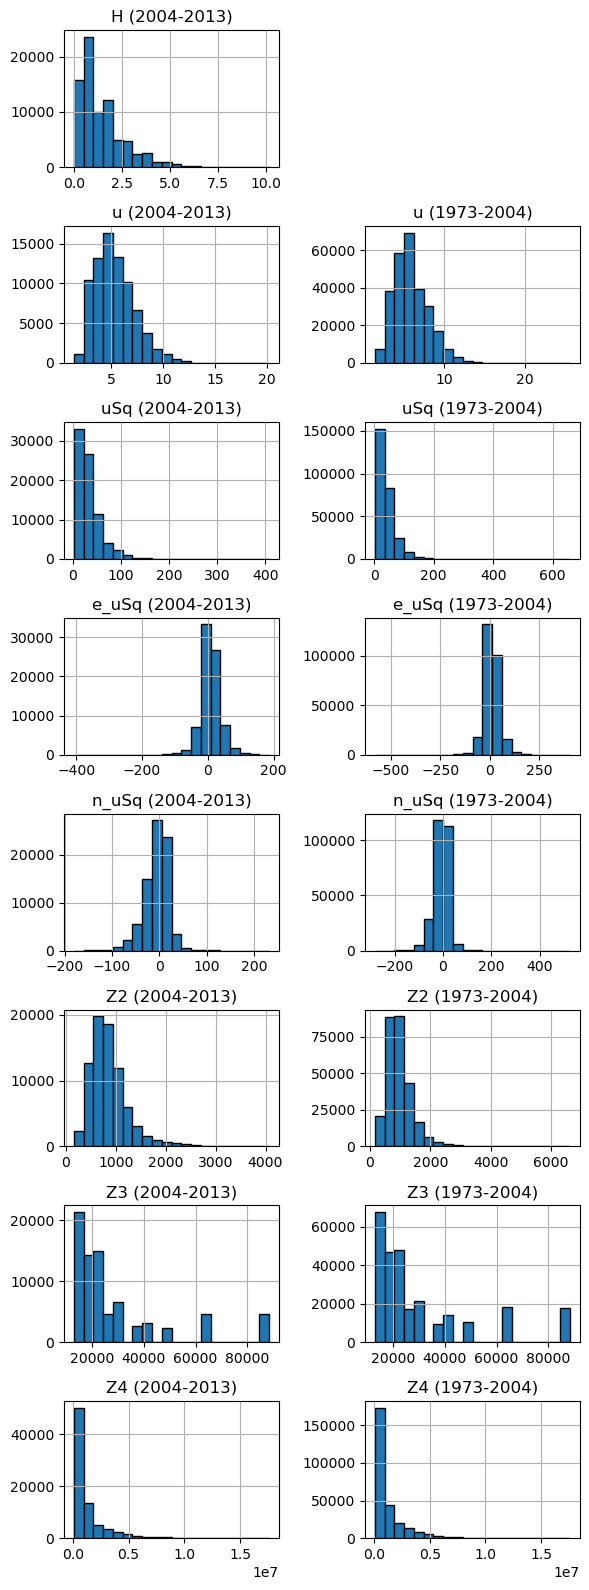

In [3]:
plt.figure(figsize=(6, 16))

# Numerical columns
num_cols = df1.columns

for i, col in enumerate(num_cols, start=1):
    # Left column: Histograms of df1 (2004-2013)
    plt.subplot(len(num_cols), 2, 2*i-1)
    df1[col].hist(bins=20, edgecolor='black')
    plt.title(f"{col} (2004-2013)")
    
    # Right column: Histograms of df2 (1973-2004)
    if i > 1:
        plt.subplot(len(num_cols), 2, 2*i)
        df2[col].hist(bins=20, edgecolor='black')
        plt.title(f"{col} (1973-2004)")

plt.tight_layout()
plt.show()

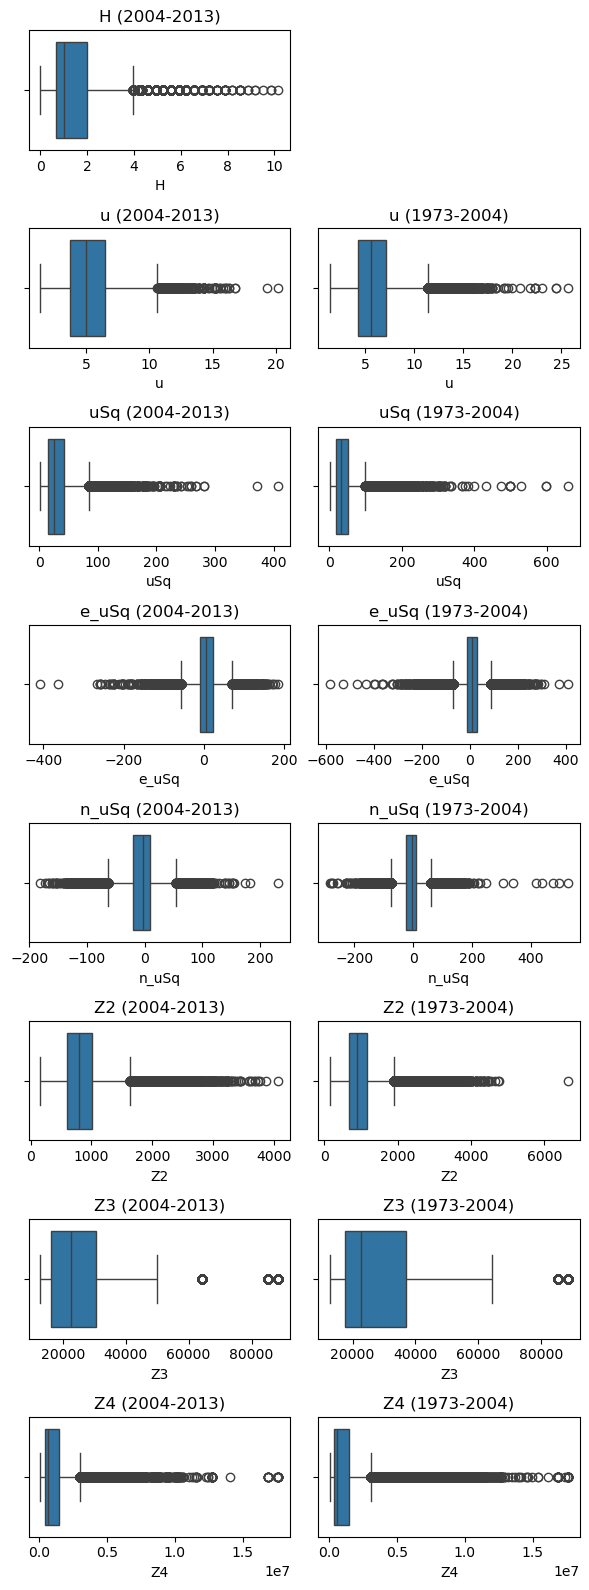

In [4]:
plt.figure(figsize=(6, 16))

# Numerical columns
num_cols = df1.columns

for i, col in enumerate(num_cols, start=1):
    # Left column: Box plots of df1 (2004-2013)
    plt.subplot(len(num_cols), 2, 2*i-1)
    sns.boxplot(data=df1, x=col)
    plt.title(f"{col} (2004-2013)")
    
    # Right column: Box plots of df2 (1973-2004)
    if i > 1:
        plt.subplot(len(num_cols), 2, 2*i)
        sns.boxplot(data=df2, x=col)
        plt.title(f"{col} (1973-2004)")

plt.tight_layout()
plt.show()

### Correlation Analysis

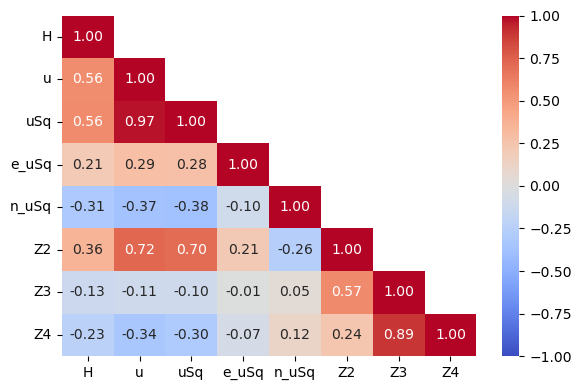

In [5]:
df_corr = df1.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(df_corr, vmin=-1, vmax=1, center=0, fmt='.2f', annot=True, 
            cmap='coolwarm', mask=np.triu(np.ones_like(df_corr), 1))

plt.tight_layout()
plt.show()

### Kolmogorov-Smirnov (KS) Test

- **Two-sample KS test**: To compare the distributions of a feature between the training set and the test set
- **Null hypothesis**: There is no significant difference between the distributions of two datasets.

#### Comparison of feature distributions between the training and test sets

In [6]:
# Train-Test split
# df_train: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2008-11-01 00:00:00 ~ 2013-10-31 23:00:00]
# df_test: [2007-11-01 00:00:00 ~ 2008-10-31 23:00:00]
split1 = pd.to_datetime('2007-10-31 23:59:00')
split2 = pd.to_datetime('2008-10-31 23:59:00')
df_train = df1[(df1.index < split1) | (df1.index > split2)]
df_test = df1[(df1.index > split1) & (df1.index < split2)]

# Data normalization
scaler = MinMaxScaler()
df_train_T = scaler.fit_transform(df_train)
df_test_T = scaler.transform(df_test)
df_train_T = pd.DataFrame(df_train_T, columns=df1.columns)
df_test_T = pd.DataFrame(df_test_T, columns=df1.columns)

# KS test
results = []
for col in df1.columns:
    statistic, p_value = ks_2samp(df_train_T[col], df_test_T[col])
    results.append((col, statistic, p_value))

ks_df = pd.DataFrame(results, columns=['Feature', 'KS Statistic', 'P-value'])
ks_df

,Feature,KS Statistic,P-value
0,H,0.024161,2.165789e-04
1,u,0.014083,8.958118e-02
2,uSq,0.014083,8.958118e-02
3,e_uSq,0.032287,1.668130e-07
4,n_uSq,0.020167,3.446459e-03
5,Z2,0.020694,2.462375e-03
6,Z3,0.008849,5.708129e-01
7,Z4,0.012247,1.906394e-01


#### Comparison of feature distributions between the 2004-2013 and 1973-2004 datasets

In [7]:
# Drop columns
df1 = df1.drop(['H'], axis=1)

# Data normalization
scaler = MinMaxScaler()
df1_T = scaler.fit_transform(df1)
df2_T = scaler.transform(df2)
df1_T = pd.DataFrame(df1_T, columns=df1.columns)
df2_T = pd.DataFrame(df2_T, columns=df2.columns)

# KS test
results = []
for col in df1.columns:
    statistic, p_value = ks_2samp(df1_T[col], df2_T[col])
    results.append((col, statistic, p_value))

ks_df = pd.DataFrame(results, columns=['Feature', 'KS Statistic', 'P-value'])
ks_df

,Feature,KS Statistic,P-value
0,u,0.122588,0.000000e+00
1,uSq,0.122588,0.000000e+00
2,e_uSq,0.062811,3.844029e-210
3,n_uSq,0.038924,6.364082e-81
4,Z2,0.138416,0.000000e+00
5,Z3,0.042513,1.860662e-96
6,Z4,0.042748,1.601888e-97
